In [1]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama


In [4]:
experiment = "tonsil"
cores = ["DonorA", "DonorE"]
datasets = [core + f"_{i}" for core in cores for i in range(1, 7)]

# Load data

In [5]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [6]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [7]:
%%capture 

adatas = []
adatas_raw = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    # df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
    #     df_morph["area"], axis=0
    # )
    # data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    
    # FPM normalize
    # sc.pp.normalize_total(adata, target_sum=1e5)
    # sc.pp.log1p(adata, base=2)
    adatas_raw.append(adata.copy())
    
    # Standard scale
    sc.pp.scale(adata)
    adatas.append(adata)
    
adata = ad.concat(adatas, join="inner")
adata_raw = ad.concat(adatas_raw, join="inner")

# Plot images

In [8]:
import palettable
h5_data_dir = p_dir / "data" / "h5"
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap

from typing import List
import matplotlib
import skimage
from skimage import measure

h5_data_dir = p_dir / "data" / "h5"

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, cell2count,  **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1]))*np.nan

    for cell, counts in tqdm(cell2count.items(), total=len(cell2count)):
        rows, cols = np.where(np.isin(mask, cell))
        img[rows, cols] = counts

    return img

def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs[2:], labels[2:]

def IMS(imgs, mz, masses):
    mz_img = imgs[np.equal(masses, mz),...][0]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(mz_img, cmap='rainbow', interpolation='quadric', vmin=0, vmax=np.percentile(mz_img, 90))  
    ax.axis('off')
    plt.title(f'{mz} m/z')
    plt.show()
    return mz_img 

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs[2:], labels[2:]

def IMS(imgs, mz, masses):
    mz_img = imgs[np.equal(masses, mz),...][0]
    # fig, ax = plt.subplots(figsize=(7,7))
    # ax.imshow(mz_img, cmap=heatmap_cmp, interpolation='quadric', vmin=0,vmax=np.percentile(mz_img, 99))  
    # ax.axis('off')
    # plt.title(f'{mz} m/z')
    # plt.show()
    return mz_img 

In [13]:
masks = get_masks(data_dir / "masks")
experiment='tonsil'

In [9]:
datasets_subset = ['DonorA_1',
 'DonorA_2',                  
 'DonorA_3',
 'DonorA_5',               
 'DonorE_1',
 'DonorA_2',                  
 'DonorE_3',
 'DonorE_4',   
]

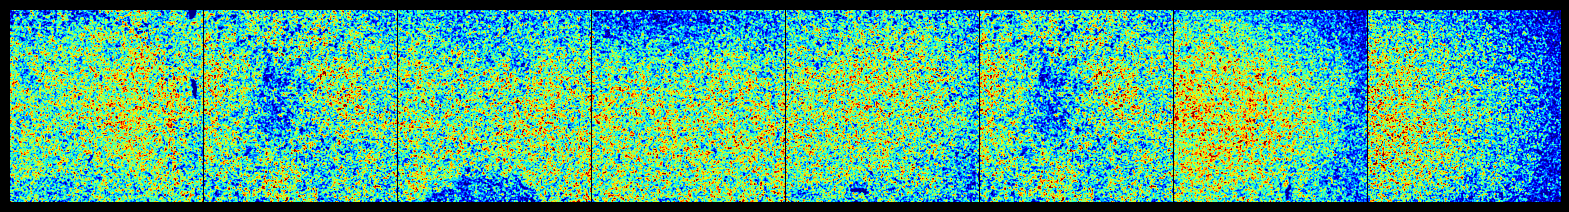

In [29]:
fig, axs = plt.subplots(1,8,figsize=(20,4), facecolor='k')
axs = axs.flatten()
channel = '95.0m/z'

for i, dataset in enumerate(datasets_subset):
    mask = masks[experiment + '_' + dataset]
    contours = get_contour(mask)

    imgs, labels = get_imgs_sims(experiment, 'auto_'+dataset)
    imgs_stack = skimage.transform.resize(imgs, (imgs.shape[0], mask.shape[0], mask.shape[0]), order=2, preserve_range=True, anti_aliasing=False)
    mean = np.mean(imgs_stack, axis=0, keepdims=False)+1

    ax = axs[i]
    ax.axis("off")
    mz = float(channel.split('m/z')[0])
    mz_img = IMS(imgs, mz, mzs)
    mz_img = skimage.transform.resize(mz_img, mask.shape, anti_aliasing=True, anti_aliasing_sigma=1)
    mz_img = mz_img 
    
    ax.imshow(mz_img, cmap='jet', interpolation=None, 
              vmin=np.percentile(mz_img, 1), 
              vmax=np.percentile(mz_img, 98))
    # for j, contour in enumerate(contours):
    #     ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="k")
    # ax.axis("off")

fig.subplots_adjust(wspace=0.01)

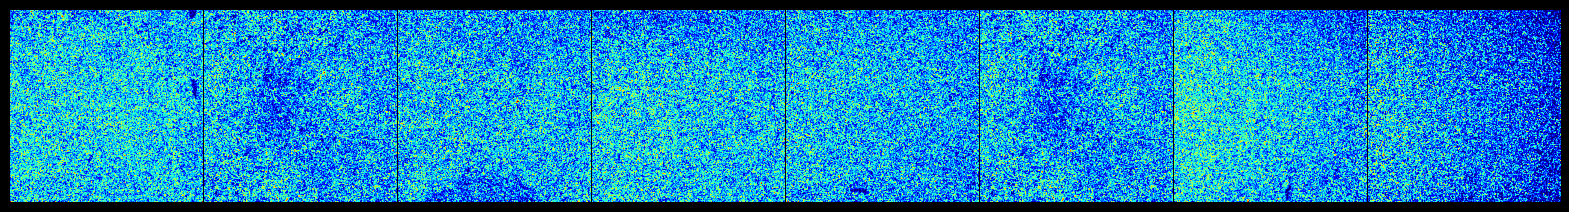

In [32]:
fig, axs = plt.subplots(1,8,figsize=(20,4), facecolor='k')
axs = axs.flatten()
channel = '95.0m/z'

for i, dataset in enumerate(datasets_subset):
    mask = masks[experiment + '_' + dataset]
    contours = get_contour(mask)

    imgs, labels = get_imgs_sims(experiment, 'auto_'+dataset)
    imgs_stack = skimage.transform.resize(imgs, (imgs.shape[0], mask.shape[0], mask.shape[0]), order=2, preserve_range=True, anti_aliasing=False)
    mean = np.mean(imgs_stack, axis=0, keepdims=False)+1

    ax = axs[i]
    ax.axis("off")
    mz = float(channel.split('m/z')[0])
    mz_img = IMS(imgs, mz, mzs)
    mz_img = skimage.transform.resize(mz_img, mask.shape, order=2, preserve_range=True, anti_aliasing=False)
    mz_img = mz_img / mean
    
    ax.imshow(mz_img, cmap='jet', interpolation=None, 
              vmin=np.percentile(mz_img, 1), 
              vmax=np.percentile(mz_img, 95))
    # for j, contour in enumerate(contours):
    #     ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="k")
    # ax.axis("off")

fig.subplots_adjust(wspace=0.01)

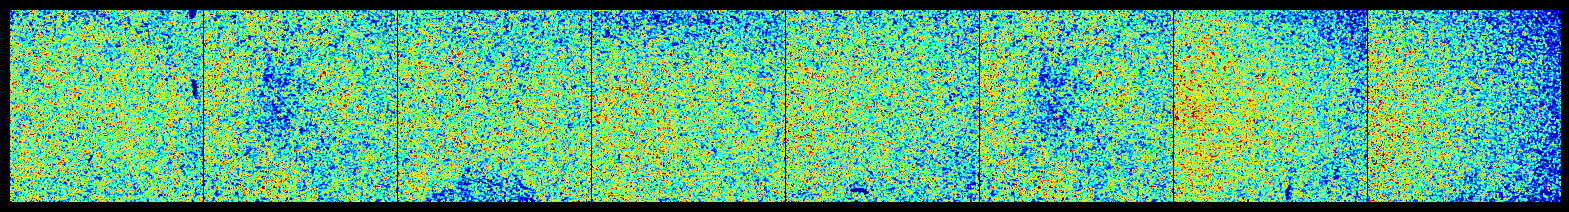

In [33]:
fig, axs = plt.subplots(1,8,figsize=(20,4), facecolor='k')
axs = axs.flatten()
channel = '95.0m/z'

for i, dataset in enumerate(datasets_subset):
    mask = masks[experiment + '_' + dataset]
    contours = get_contour(mask)

    imgs, labels = get_imgs_sims(experiment, 'auto_'+dataset)
    imgs_stack = skimage.transform.resize(imgs, (imgs.shape[0], mask.shape[0], mask.shape[0]), order=2, preserve_range=True, anti_aliasing=False)
    mean = np.mean(imgs_stack, axis=0, keepdims=False)+1

    ax = axs[i]
    ax.axis("off")
    mz = float(channel.split('m/z')[0])
    mz_img = IMS(imgs, mz, mzs)
    mz_img = skimage.transform.resize(mz_img, mask.shape, anti_aliasing=True, anti_aliasing_sigma=1)
    mz_img = mz_img/mean 
    
    ax.imshow(mz_img, cmap='jet', interpolation=None, 
              vmin=np.percentile(mz_img, 1), 
              vmax=np.percentile(mz_img, 98))
    # for j, contour in enumerate(contours):
    #     ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="k")
    # ax.axis("off")

fig.subplots_adjust(wspace=0.01)

  0%|          | 0/2711 [00:00<?, ?it/s]

  0%|          | 0/3047 [00:00<?, ?it/s]

  0%|          | 0/2107 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/3401 [00:00<?, ?it/s]

  0%|          | 0/3047 [00:00<?, ?it/s]

  0%|          | 0/3037 [00:00<?, ?it/s]

  0%|          | 0/3150 [00:00<?, ?it/s]

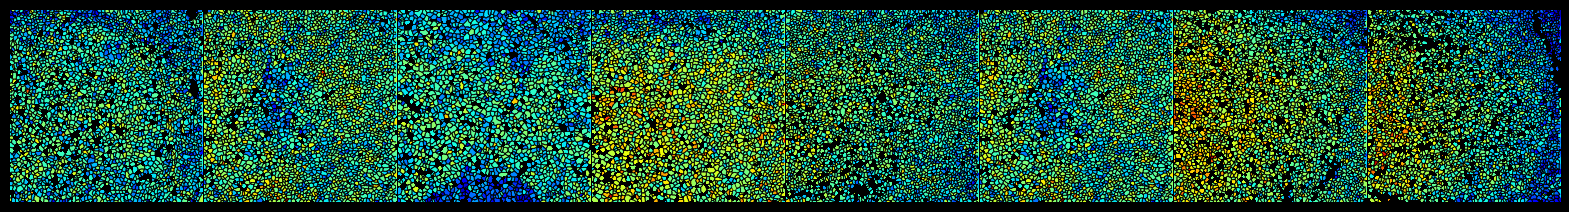

In [41]:
fig, axs = plt.subplots(1,8,figsize=(20,4), facecolor='k')
axs = axs.flatten()
channel = '95.0m/z'

for i, dataset in enumerate(datasets_subset):
    mask = masks[experiment + '_' + dataset]
    contours = get_contour(mask)

    imgs, labels = get_imgs_sims(experiment, 'auto_'+dataset)
    imgs_stack = skimage.transform.resize(imgs, (imgs.shape[0], mask.shape[0], mask.shape[0]), order=2, preserve_range=True, anti_aliasing=False)
    mean = np.mean(imgs_stack, axis=0, keepdims=False)+1

    ax = axs[i]
    ax.axis("off")
    mz = float(channel.split('m/z')[0])
    mz_img = IMS(imgs, mz, mzs)
    mz_img = skimage.transform.resize(mz_img, mask.shape, anti_aliasing=False)
    mz_img = mz_img/mean 
    
    props = skimage.measure.regionprops_table(mask, mz_img, properties=['label', 'intensity_mean'])
    cell2count = dict(zip(props['label'], props['intensity_mean']))
    
    img = create_clustered_cell(mask, cell2count)
    
    ax = axs[i]
    ax.axis("off")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('darkblue')
    ax.imshow(img, cmap='jet', vmin=np.nanpercentile(img, 0), vmax=np.nanpercentile(img, 100))
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="k")

fig.subplots_adjust(wspace=0.01)

  0%|          | 0/2711 [00:00<?, ?it/s]

  0%|          | 0/3047 [00:00<?, ?it/s]

  0%|          | 0/2107 [00:00<?, ?it/s]

  0%|          | 0/2540 [00:00<?, ?it/s]

  0%|          | 0/3401 [00:00<?, ?it/s]

  0%|          | 0/3047 [00:00<?, ?it/s]

  0%|          | 0/3037 [00:00<?, ?it/s]

  0%|          | 0/3150 [00:00<?, ?it/s]

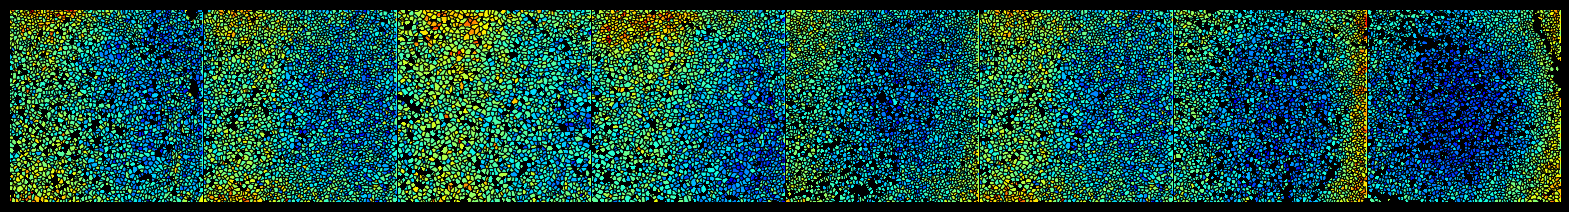

In [22]:
fig, axs = plt.subplots(1,8,figsize=(20,5), facecolor='k')
axs = axs.flatten()

for i, dataset in enumerate(datasets_subset):
    mask = masks[experiment + '_' + dataset]
    contours = get_contour(mask)

    adata_subset = adata[adata.obs['Dataset'] == dataset, channel[:-3]]
    
    # Get label2cell dict
    cells = adata_subset.obs['Cell'].to_list()
    counts = adata_subset.X.flatten()
    cell2count = dict(zip(cells, counts))

    img = create_clustered_cell(mask, cell2count)
    
    ax = axs[i]
    ax.axis("off")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('darkblue')
    ax.imshow(img, cmap='jet', vmin=np.nanpercentile(img, 0), vmax=np.nanpercentile(img, 100))
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="k")

fig.subplots_adjust(wspace=0.01)